In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time

## 1 - Twitter API Authorization

In [2]:
import tweepy
import sys
import csv
import time

In [3]:
consumer_key = "???"
consumer_secret = "???"
access_token = "???"
access_token_secret = "???"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

check [tweepy API](http://tweepy.readthedocs.io/en/v3.5.0/api.html).

- `api.user_timeline`: return my tweets
- `api.home_timeline`: return tweets on my home page
- `items()`, `pages()`: are iterable. 

## 2 - Data Scraping

According to [Top Emojis of World Emoji Day](https://blog.emojipedia.org/top-emojis-of-world-emoji-day/), we will only search for tweets with the top 9 emojis. If there are two emojis, we will .... Refer to [here](https://unicode.org/emoji/charts/full-emoji-list.html) for unicode.
- 😂 Face With Tears Of Joy:     $\qquad$ `0` - U+1F602
- 😍 Smiling Face With Heart-Eyes: 
- ❤️ Red heart
- 😀 Grinning Face: $\quad$ `1` - U+1F600
- 😎 Smiling Face With Sunglasses
- 🎉 Party Popper: $\qquad$ `2` - U+1F389
- 😊 Smiling Face With Smiling Eyes
- 👍 Thumbs Up: $\qquad$ `3` - U+1F44D
- 💩 Pile Of Poo: $\quad$ `4` - U+1F4A9

I could also extract tweets for bigger categories of emoji, but the procedure is very similar. In this project I will select the above five emojis with the labels in shaded fonts for a test run of the sentiment analysis.

### 2.1 - No stream

In [15]:
# https://stackoverflow.com/questions/38872195/tweepy-exclude-retweets

query = [u"\U0001F602",u"\U0001F600",u"\U0001F389",u"\U0001F44D",u"\U0001F4A9"]

idx = 2
csvFile = open('emoji_new_'+str(idx)+'.csv', 'a')
#Use csv Writer
csvWriter = csv.writer(csvFile)
csvWriter.writerow(["Time", "tweet", "retweet num","tweet id"])
for tweet in tweepy.Cursor(api.search,q=[query[idx]+' -filter:retweets'],since="2017-01-01",until="2017-12-31",lang="en").items(100000):
    csvWriter.writerow([tweet.created_at, tweet.text, tweet.retweet_count, tweet.id])
#    csvWriter.writerow(["Time":tweet.created_at, "tweet":tweet.text, "retweet num":tweet.retweet_count, "tweet id":tweet.id])
csvFile.close()

In [38]:
import pandas as pd
#f = pd.read_json('emoji1 copy.json', lines=True)
f = pd.read_csv('e4b.csv')
print(f.shape)
f.head()

(2586, 5)


,2018-04-06 21:07:12,@dkrwilliams @seanhannity @jimmykimmel @colbertlateshow @CBS F U C K O F F V L A D We see you. 🇷🇺🇷🇺🇷🇺🇷🇺🇷🇺🇷🇺🇷🇺🇷🇺… https://t.co/op8BvQkZOk,0,982364119507619842,ghostofnero
0,2018-04-06 20:55:54,Just listen to the all scripted 💩in unison wit...,5,982361278550302720,emfvet78
1,2018-04-06 20:55:30,@President1Trump @GET4208 U know when someone ...,2,982361175575818240,ElaineC26681844
2,2018-04-06 20:38:56,I Told u Stay Down Cause I Know 💩 Could G...,0,982357008526569472,aaron_w26
3,2018-04-06 20:38:39,@Egyptiankingsal @EmmaLFC1 Oh my I will let u ...,0,982356936288071680,WilsonFlair
4,2018-04-06 20:36:23,@joebook73 @beer_mood @WhiteHouse There ya go ...,0,982356366554738688,simply_ss598


### 2.2 - Stream

Click [here](https://developer.twitter.com/en/docs/tweets/filter-realtime/guides/basic-stream-parameters) for Standard streaming API request parameters. The github is [here](https://github.com/tweepy/tweepy/blob/v3.4.0/tweepy/streaming.py).

In [4]:
import time
import json

class MyListener(tweepy.StreamListener):
    """
    set a time limit for the stream
    """
    def __init__(self, time_limit=10,label=0):
        self.start_time = time.time()
        self.limit = time_limit
        self.label = label
        super(MyListener, self).__init__()
        
    def on_data(self, data):
        if (time.time() - self.start_time) < self.limit:
            t = json.loads(data)
            with open('emoji_'+str(self.label)+'.csv','a',newline='\n') as f:
                if not t['text'].startswith('RT'):
                    writer = csv.DictWriter(f,fieldnames=['tweet','label'])
                    writer.writerow({'tweet':t['text'],'label': self.label})              
            return True
        else:
            return False
        
    def on_error(self, status_code):
        if status_code == 420 or status_code == 429:
            print('rate limit error: status code is ', status_code)
            return False
        
class MyListener_notimelimit(tweepy.StreamListener):
    """
    there is no time limit, the stream will be stopped by hand
    """
    def __init__(self, label=0):
        self.label = label
        super(MyListener_notimelimit, self).__init__()
        
    def on_data(self, data):
        t = json.loads(data)
        with open('emoji_'+str(self.label)+'.csv','a',newline='\n') as f:
            if not t['text'].startswith('RT'):
                writer = csv.DictWriter(f,fieldnames=['tweet','label'])
                writer.writerow({'tweet':t['text'],'label': self.label})              
        return True
        
    def on_error(self, status_code):
        if status_code == 420 or status_code == 429:
            print('rate limit error: status code is ', status_code)
            return False


In [5]:
def scrape_emoji(query,idx,time_limit=0,first=False):    
    '''
    (1) time_limit indicates the length of running time, 
    (2) first denotes whether it is the first time to run, because if False, don't write the header
    '''
    if first:
        filename = 'emoji_' + str(idx) + '.csv'
        with open(filename,'w',newline='\n') as f:
            writer = csv.DictWriter(f,fieldnames=['tweet','label'])
            writer.writeheader()
    # if there is NO time limit
    if time_limit==0: 
        twitterStream = tweepy.Stream(auth, MyListener_notimelimit(label=idx))
    # if there is time limit
    else:
        twitterStream = tweepy.Stream(auth, MyListener(time_limit=time_limit,label=idx))
    twitterStream.filter(track=[query[idx]+' -filter:retweets'], languages = ["en"], stall_warnings = True, async=True)

In [49]:
query = [u"\U0001F602",u"\U0001F600",u"\U0001F389",u"\U0001F44D",u"\U0001F4A9"]
scrape_emoji(query,idx=4,time_limit=0,first=False)

### 2.3 - Concatenation

In [3]:
filenames = ['./inputs/emoji_nostream_' + str(idx) + '.csv' for idx in range(5)]
dfs = [pd.read_csv(filename) for filename in filenames]
for i in range(5):
    print('df{}.shape= '.format(i), dfs[i].shape)

df0.shape=  (2376, 2)
df1.shape=  (1886, 2)
df2.shape=  (4607, 2)
df3.shape=  (1860, 2)
df4.shape=  (2132, 2)


[DataFrame.reset_index](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html). I set drop=True to remove the old index. [DataFrame.sample](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html).

In [4]:
dfs[2] = dfs[2].sample(frac=0.5,random_state=99).reset_index(drop=True)
for i in range(5):
    print('length of df{} ='.format(i),len(dfs[i]))

length of df0 = 2376
length of df1 = 1886
length of df2 = 2304
length of df3 = 1860
length of df4 = 2132


Now the five categories have similar sizes. We are good to go.

In [5]:
df_raw = pd.concat(dfs)

#shuffle the row to mix the five categories
df_raw = df_raw.sample(frac=1,random_state=99).reset_index(drop=True)
df_raw.head()

,tweet,label
0,"RT @denmatai190: | 👑411K FOLLOWERS!!!👑\n|∧∧""""\...",3
1,"@6CentsRose My nieces and nephews were young, ...",1
2,@HobiLove94 Happy Birthday 🎉🎈,2
3,@bravoholclique Me! I never get a chance to wa...,1
4,RT @RoanhorseBex: 🎉ANNOUNCEMENT🎉That Anasazi-i...,2


## 3 - data cleaning

**to-do list:**
- `duplicates`: there should be some tweets with more than one emoji, I will drop them all duplicate occurences. 
- `#hashtag`: I will keep them because it's likely they convey useful messages, I will delete only the hashtag symbol.
- `@username`, `emoji`, `punctuations`, `r'https?://'`: drop all non-alphanumeric symbols `\W`, or maybe `r'[^a-zA-Z]*'`
- convert to `lowercase`
- ...

I will be using python3 [regex](https://docs.python.org/3.4/library/re.html) for most of the tasks.

In [10]:
# check duplicates
df_raw.tweet.duplicated().value_counts()

False    7666
True     2892
Name: tweet, dtype: int64

[DataFrame.drop_duplicates](http://pandas.pydata.org/pandas-docs/version/0.17/generated/pandas.DataFrame.drop_duplicates.html): the default for `keep` is `'first'`, which means drop duplicates except the first occurence. I will drop all occurences, so `keep=False`. 

In [11]:
df = df_raw.drop_duplicates(['tweet'],keep=False)

print(df.tweet.duplicated().value_counts())
df.label.value_counts(normalize=True)

False    7066
Name: tweet, dtype: int64


0    0.236202
4    0.221059
1    0.207897
3    0.173224
2    0.161619
Name: label, dtype: float64

In [352]:
df1 = df.copy()

In [353]:
# remove the leading 'RT'
df1['tweet'] = df['tweet'].str.replace(r'^ *RT ', ' ')
print(df1['tweet'].str.count(r'^ *RT').sum())
df1.head()

0


,tweet,label
0,"@denmatai190: | 👑411K FOLLOWERS!!!👑\n|∧∧""""\n|...",3
1,"@6CentsRose My nieces and nephews were young, ...",1
2,@HobiLove94 Happy Birthday 🎉🎈,2
3,@bravoholclique Me! I never get a chance to wa...,1
4,@RoanhorseBex: 🎉ANNOUNCEMENT🎉That Anasazi-ins...,2


In [354]:
# remove @
df1['tweet'] = df1['tweet'].str.replace(r'@[a-zA-Z0-9_]+', ' ')
print(df1.tweet.str.count(r'@[a-zA-Z0-9_]+').sum())
df1.head()

0


,tweet,label
0,": | 👑411K FOLLOWERS!!!👑\n|∧∧""""\n| * ¯ ³¯)Chu...",3
1,"My nieces and nephews were young, so it was ...",1
2,Happy Birthday 🎉🎈,2
3,Me! I never get a chance to watch it live! 😀,1
4,: 🎉ANNOUNCEMENT🎉That Anasazi-inspired epic f...,2


In [265]:
# remove hashtag symbol
df1['tweet'] = df1['tweet'].str.replace(r'#\S*', ' ')
print(df1.tweet.str.count(r'@[a-zA-Z0-9_]+').sum())
df1.head()

0


,tweet,label
0,": | 👑411K FOLLOWERS!!!👑\n|∧∧""""\n| * ¯ ³¯)Chu...",3
1,"My nieces and nephews were young, so it was ...",1
2,Happy Birthday 🎉🎈,2
3,Me! I never get a chance to watch it live! 😀,1
4,: 🎉ANNOUNCEMENT🎉That Anasazi-inspired epic f...,2


In [355]:
# remove http:// and https://
df1['tweet'] = df1['tweet'].str.replace(r'https?://[a-zA-Z0-9/\.]*', ' ')
print(df1['tweet'].str.count(r'https://[a-zA-Z0-9_]*').sum())
df1.tweet.head(10)

0


0       : | 👑411K FOLLOWERS!!!👑\n|∧∧""\n| * ¯ ³¯)Chu...
1       My nieces and nephews were young, so it was ...
2                                     Happy Birthday 🎉🎈
3          Me! I never get a chance to watch it live! 😀
4       : 🎉ANNOUNCEMENT🎉That Anasazi-inspired epic f...
5                           😂😂😂 you shoulda got footage
6                              :   happy birthday!!!🎉🎂🎁
8         I just had to know that 💩 look sus as hell 😂😂
9                                  Absolute class 👍 👍 👍
10    The CW officially renewed Supernatural! There’...
Name: tweet, dtype: object

In [356]:
# I decide to remove all non alphanumeric characters
df1['tweet']= df1['tweet'].str.replace(r'[a-zA-Z]*\'[a-zA-Z]*','')
df1['tweet']= df1['tweet'].str.replace(r'\d+[a-zA-Z]{,2}',' ')
df1['tweet']= df1['tweet'].str.replace(r'[^a-zA-Z]',' ')
df1.tweet.head(10)

0              FOLLOWERS                    Chu Maki...
1       My nieces and nephews were young  so it was ...
2                                     Happy Birthday   
3          Me  I never get a chance to watch it live   
4          ANNOUNCEMENT That Anasazi inspired epic f...
5                               you shoulda got footage
6                                  happy birthday      
8         I just had to know that   look sus as hell   
9                                  Absolute class      
10    The CW officially renewed Supernatural  There ...
Name: tweet, dtype: object

In [357]:
# remove emoji

# https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
pattern = "["u"\U0001F600-\U0001F64F"u"\U0001F300-\U0001F5FF"u"\U0001F680-\U0001F6FF"u"\U0001F1E0-\U0001F1FF""]+"
df1['tweet']= df1['tweet'].str.replace(pattern,' ')

,tweet,label
0,FOLLOWERS Chu Maki...,3
1,My nieces and nephews were young so it was ...,1
2,Happy Birthday,2
3,Me I never get a chance to watch it live,1
4,ANNOUNCEMENT That Anasazi inspired epic f...,2
5,you shoulda got footage,0
6,happy birthday,2
8,I just had to know that look sus as hell,4
9,Absolute class,3
10,The CW officially renewed Supernatural There ...,2


In [358]:
# convert to lowercase

df1['tweet']= df1['tweet'].str.lower()
df1.tweet.head(10)

0              followers                    chu maki...
1       my nieces and nephews were young  so it was ...
2                                     happy birthday   
3          me  i never get a chance to watch it live   
4          announcement that anasazi inspired epic f...
5                               you shoulda got footage
6                                  happy birthday      
8         i just had to know that   look sus as hell   
9                                  absolute class      
10    the cw officially renewed supernatural  there ...
Name: tweet, dtype: object

In [359]:
# remove extra white space characters

df1['tweet'] = df1['tweet'].apply(lambda x: ' '.join(x.split()))
df1['tweet'].head()

0    followers chu makina yui thank you guys so muc...
1    my nieces and nephews were young so it was my ...
2                                       happy birthday
3             me i never get a chance to watch it live
4    announcement that anasazi inspired epic fantas...
Name: tweet, dtype: object

In [237]:
idx = 99
print(df_raw.tweet[idx],'\n',df1.tweet[idx], '\n','LABEL= ',df1.label[idx])

RT @mozilla: Twenty years! 🎂 🎉

It’s been two decades since we first logged on as the Mozilla project and got started bringing together the… 
 twenty years it s been two decades since we first logged on as the mozilla project and got started bringing together the 
 LABEL=  2


In [272]:
query = [u"\U0001F602",u"\U0001F600",u"\U0001F389",u"\U0001F44D",u"\U0001F4A9"]
print(query)
df1['emoji'] = df1['label'].apply(lambda i: query[int(i)])
df1.head()

['😂', '😀', '🎉', '👍', '💩']


,tweet,label,emoji
0,k followers chu makina yui thank you guys so m...,3,👍
1,my nieces and nephews were young so it was my ...,1,😀
2,happy birthday,2,🎉
3,me i never get a chance to watch it live,1,😀
4,announcement that anasazi inspired epic fantas...,2,🎉


In [348]:
df1['tweet'] = df_raw['tweet'].apply(lambda x: ' '.join(x.split()))

In [342]:
df1['label'] = df1['label'].apply(lambda i: int(i))

In [13]:
# combine all together

def preprocessing(df):
    df1 = df.copy()
    df1['tweet'] = df1['tweet'].str.replace(r'^ *RT ', ' ')
    df1['tweet'] = df1['tweet'].str.replace(r'@[a-zA-Z0-9_]+', ' ')
    #df1['tweet'] = df1['tweet'].str.replace(r'#\S*', ' ')
    df1['tweet'] = df1['tweet'].str.replace(r'https?://[a-zA-Z0-9/\.]*', ' ')
    df1['tweet']= df1['tweet'].str.replace(r'[a-zA-Z]*\'[a-zA-Z]*','')
    df1['tweet']= df1['tweet'].str.replace(r'\d+[a-zA-Z]{,2}',' ')
    df1['tweet']= df1['tweet'].str.replace(r'[^a-zA-Z]',' ')
    pattern = "["u"\U0001F600-\U0001F64F"u"\U0001F300-\U0001F5FF"u"\U0001F680-\U0001F6FF"u"\U0001F1E0-\U0001F1FF""]+"
    df1['tweet']= df1['tweet'].str.replace(pattern,' ')
    df1['tweet']= df1['tweet'].str.lower()
    df1['tweet'] = df1['tweet'].apply(lambda x: ' '.join(x.split()))
    df1['tweet'] = df1['tweet'].apply(lambda x: x.strip())
    #df1 = df1.iloc[:,:][len(df1['tweet'])==0]    
    df1['label'] = df1['label'].apply(lambda i: int(i))
    df1 = df1.drop_duplicates(['tweet'],keep=False)
    df1 = df1[df1.notnull().tweet]
    return df1

df1 = preprocessing(df)
print(df1.head())


                                               tweet  label
0  followers chu makina yui thank you guys so muc...      3
1  my nieces and nephews were young so it was my ...      1
3           me i never get a chance to watch it live      1
4  announcement that anasazi inspired epic fantas...      2
5                            you shoulda got footage      0


In [35]:
df1 = df1[df1.notnull().tweet]
df1.to_csv('./inputs/emoji_hashtag.csv',index=False)

## 4 - Model

There are many ways to represent text with numerical values. First I will use `CountVectorizer` and `TfidfVectorizer` which are based on the frequency of appearance of words. In Neural Network, I will turn to `Word2Vec` embedding, which dig into the meaning of words rather than pure word counting.

In [4]:
df1 = pd.read_csv('./inputs/emoji_hashtag.csv')
df1.head()

,tweet,label
0,followers chu makina yui thank you guys so muc...,3
1,my nieces and nephews were young so it was my ...,1
2,me i never get a chance to watch it live,1
3,announcement that anasazi inspired epic fantas...,2
4,you shoulda got footage,0


In [5]:
df1.isnull().tweet.value_counts()

False    6229
Name: tweet, dtype: int64

In [6]:
# train test split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df1,test_size=0.2,random_state=99)
train.shape

(4983, 2)

In [7]:
trainX, trainY = train['tweet'], train['label']
testX, testY = test['tweet'], test['label']

In [8]:
# check the distribution, should have been shuffled

print('in training set:\n',trainY.value_counts(normalize=True))
print('in testing set:\n',testY.value_counts(normalize=True))

in training set:
 0    0.258077
4    0.224363
1    0.205097
3    0.170179
2    0.142284
Name: label, dtype: float64
in testing set:
 0    0.252809
4    0.210273
1    0.206260
3    0.179775
2    0.150883
Name: label, dtype: float64


### 4.1 - kNN

In this subsection, I will use TF-IDF to implement a kNN alogrithm for our text classification, as introduced in [Procedia Engineering 69 (2014) 1356](https://www.sciencedirect.com/science/article/pii/S1877705814003750).

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,mean_squared_error

In [10]:
vect = TfidfVectorizer(
#                ngram_range = (1,4),
                stop_words = 'english',
                smooth_idf = 1,
                max_features = 1000
            )

# sparse matrix for NB Classifier
train_matrix = vect.fit_transform(trainX)
test_matrix = vect.transform(testX)

In [11]:
# attributes of the vectorizer

vocab = vect.vocabulary_
stopwords = vect.stop_words_
print('The type of vect is: ',type(vocab),'\n','the size of the corpus is: ',len(vocab),'\n','the size of the stop words is: ',len(stopwords),'\n','The stop words include:\n',stopwords)



The type of vect is:  <class 'dict'> 
 the size of the corpus is:  1000 
 the size of the stop words is:  7287 
 The stop words include:
 {'mfc', 'including', 'lake', 'ch', 'bihh', 'extended', 'candidate', 'pot', 'passion', 'worlds', 'offfffff', 'leftist', 'vit', 'preaching', 'cou', 'desiigner', 'bta', 'philly', 'regina', 'lessons', 'alternate', 'illustrates', 'known', 'wyd', 'smoking', 'bezoz', 'disunomics', 'grats', 'perkins', 'tcrwp', 'happin', 'mortar', 'persona', 'mashup', 'quiz', 'ben', 'steven', 'button', 'officials', 'varchie', 'nickel', 'dressed', 'endless', 'study', 'emoji', 'trumps', 'yaaaaaaaasssss', 'europeforc', 'scream', 'destined', 'eggs', 'nnly', 'ava', 'deleted', 'leaders', 'changes', 'consortium', 'convenient', 'dementia', 'puss', 'september', 'movle', 'yorker', 'goldberg', 'conormcgregor', 'iniesta', 'teddy', 'abv', 'erm', 'lack', 'yesss', 'fossil', 'power', 'phool', 'liverpool', 'mania', 'tu', 'thee', 'rhode', 'moss', 'sheesh', 'cuban', 'ca', 'applaud', 'photocard'

In [12]:
k_range = range(1,20)
scores = []

# find the best k value in k_range
for k in k_range:
    print("k = " + str(k) + " begin ")
    start = time.time()
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_matrix,trainY)
    test_pred = knn.predict(test_matrix)
    acc = (test_pred == testY).value_counts(normalize=True)
    accuracy = acc.loc[True]
    scores.append(accuracy)
    end = time.time()
    print("Complete time: " + str(end-start) + " Secs.")

k = 1 begin 
Complete time: 0.08065366744995117 Secs.
k = 2 begin 
Complete time: 0.0665128231048584 Secs.
k = 3 begin 
Complete time: 0.07224893569946289 Secs.
k = 4 begin 
Complete time: 0.06606292724609375 Secs.
k = 5 begin 
Complete time: 0.06430411338806152 Secs.
k = 6 begin 
Complete time: 0.061276912689208984 Secs.
k = 7 begin 
Complete time: 0.06363582611083984 Secs.
k = 8 begin 
Complete time: 0.07131791114807129 Secs.
k = 9 begin 
Complete time: 0.06797385215759277 Secs.
k = 10 begin 
Complete time: 0.0611720085144043 Secs.
k = 11 begin 
Complete time: 0.06769919395446777 Secs.
k = 12 begin 
Complete time: 0.06765627861022949 Secs.
k = 13 begin 
Complete time: 0.06452178955078125 Secs.
k = 14 begin 
Complete time: 0.07288599014282227 Secs.
k = 15 begin 
Complete time: 0.06782984733581543 Secs.
k = 16 begin 
Complete time: 0.06703472137451172 Secs.
k = 17 begin 
Complete time: 0.06558394432067871 Secs.
k = 18 begin 
Complete time: 0.07046079635620117 Secs.
k = 19 begin 
Comple

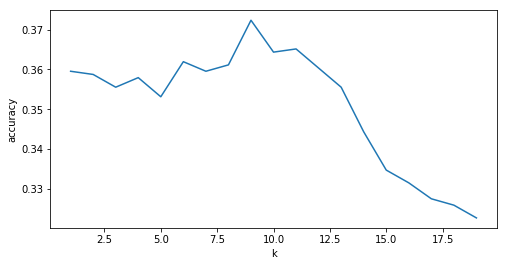

In [13]:
k_range = range(1,20)
plt.figure(figsize=(8,4))
plt.plot(k_range,scores)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.show()

In [14]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(train_matrix,trainY)
train_pred = knn.predict(train_matrix)
test_pred = knn.predict(test_matrix)

print((train_pred == trainY).value_counts(normalize=True))
print((test_pred == testY).value_counts(normalize=True))

True     0.510335
False    0.489665
Name: label, dtype: float64
False    0.638844
True     0.361156
Name: label, dtype: float64


Using kNN, the accuracy on test set can reaches **36%** from **34%** after putting back the hashtag words and choose `max_features=1000`.

### 4.2 - Naive Bayes

In [15]:
from sklearn.naive_bayes import MultinomialNB 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
#                ngram_range = (1,4),
                stop_words = 'english',
                smooth_idf = 1,
#                max_features = 10000
            )

# sparse matrix for NB Classifier
train_matrix = vectorizer.fit_transform(trainX)
test_matrix = vectorizer.transform(testX)
print(vectorizer.vocabulary_)
print(train_matrix)

{'sports': 6835, 'bras': 887, 'cups': 1706, 'asap': 366, 'field': 2600, 'looking': 4277, 'good': 2997, 'ready': 5874, 'bless': 744, 'airwaves': 145, 'sunday': 7062, 'april': 319, 'pm': 5511, 'special': 6793, 'guest': 3107, 'looked': 4274, 'mirror': 4659, 'started': 6899, 'honest': 3383, 'things': 7326, 'fromboytoman': 2790, 'just': 3861, 'passed': 5288, 'revenue': 6050, 'fastest': 2529, 'hit': 3336, 'number': 5048, 'calendar': 1047, 'year': 8190, 'ok': 5102, 'wo': 8059, 'mxm': 4824, 'guys': 3127, 'annoying': 265, 'hai': 3145, 'wishing': 8049, 'cute': 1722, 'little': 4215, 'stylish': 7020, 'star': 6889, 'alluayaan': 189, 'happy': 3190, 'birthday': 708, 'fans': 2508, 'god': 2976, 'customerservice': 1720, 'commonplace': 1456, 'help': 3293, 'dont': 2050, 'like': 4183, 'im': 3553, 'high': 3318, 'problem': 5659, 'says': 6279, 'lol': 4265, 'phone': 5412, 'weird': 7953, 'nope': 5008, 'went': 7964, 'having': 3235, 'passport': 5292, 'kalinga': 3877, 'kingdom': 3953, 'satan': 6259, 'loves': 4315,

In [17]:
clf_NB = MultinomialNB()
clf_NB.fit(train_matrix, trainY)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [18]:
cross_val = cross_val_score(clf_NB, train_matrix,trainY, cv = 5, scoring= 'accuracy')
print(cross_val)
print ("mean score for 10-fold cross validation: ", np.mean(cross_val))

[0.44744745 0.4488978  0.44834504 0.46733668 0.45774648]
mean score for 10-fold cross validation:  0.45395468808685413


In [19]:
# accuracy on training set

pred_train = clf_NB.predict(train_matrix)
(pred_train==trainY).value_counts(normalize=True)

True     0.822998
False    0.177002
Name: label, dtype: float64

In [20]:
# accuracy on test set

pred = clf_NB.predict(test_matrix)
(pred==testY).value_counts(normalize=True)

False    0.540931
True     0.459069
Name: label, dtype: float64

In [21]:
# confusion matrix

print('The confusion matrix:\n',confusion_matrix(testY,pred))

The confusion matrix:
 [[224  37   2   7  45]
 [112  78  12  26  29]
 [ 35  36 102   8   7]
 [ 78  56  11  41  38]
 [101  18   2  14 127]]


In [22]:
# comare with CountVectorizer

from sklearn.feature_extraction.text import CountVectorizer

vectorizer1 = CountVectorizer()

data_train_count = vectorizer1.fit_transform(trainX)
data_test_count  = vectorizer1.transform(testX)

clf_NB1 = MultinomialNB()
clf_NB1.fit(data_train_count, trainY)

# accuracy on training set
pred_train1 = clf_NB1.predict(data_train_count)
print((pred_train1==trainY).value_counts(normalize=True))

# accuracy on test set
pred_test1 = clf_NB1.predict(data_test_count)
print((pred_test1==testY).value_counts(normalize=True))

True     0.81477
False    0.18523
Name: label, dtype: float64
False    0.508828
True     0.491172
Name: label, dtype: float64


The result of CountVectorizer() is close to that of TfidfVectorizer. On the test set, the accuracy reaches **50.8%**.

### 4.3 - SVM

http://scikit-learn.org/stable/modules/svm.html

In [23]:
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [24]:
vect = TfidfVectorizer(
#                ngram_range = (1,4),
                stop_words = 'english',
                smooth_idf = 1,
                max_features=5000
            )

# sparse matrix for NB Classifier
train_matrix = vect.fit_transform(trainX)
test_matrix = vect.transform(testX)

clf_svm = Pipeline([("clf_svm",SVC(kernel="poly",degree=20,coef0=1,C=100))])
#clf_svm = Pipeline([("clf_svm",SVC(kernel="rbf",gamma=5,C=0.001))])
clf_svm.fit(train_matrix,trainY)

Pipeline(memory=None,
     steps=[('clf_svm', SVC(C=100, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=20, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [25]:
cross_val = cross_val_score(clf_svm, train_matrix,trainY, cv = 5, scoring= 'accuracy')
print(cross_val)
print ("mean score for 5-fold cross validation: ", np.mean(cross_val))

[0.42442442 0.40881764 0.43430291 0.4361809  0.42655936]
mean score for 5-fold cross validation:  0.4260570458161156


In [26]:
# accuracy on training set
pred_train = clf_svm.predict(train_matrix)
print((pred_train==trainY).value_counts(normalize=True))
print(accuracy_score(pred_train,trainY))

# accuracy on test set
pred_test = clf_svm.predict(test_matrix)
print((pred_test==testY).value_counts(normalize=True))
print(accuracy_score(pred_test,testY))

True     0.599839
False    0.400161
Name: label, dtype: float64
0.5998394541440899
False    0.580257
True     0.419743
Name: label, dtype: float64
0.41974317817014445


It helps to adjust the value of `max_features`.

In [27]:
# confusion matrix

print('The confusion matrix:\n',confusion_matrix(testY,pred))

The confusion matrix:
 [[224  37   2   7  45]
 [112  78  12  26  29]
 [ 35  36 102   8   7]
 [ 78  56  11  41  38]
 [101  18   2  14 127]]


## 5 - Neural Network, LSTM

`Logistic Regression` (LR) wouldn't be as good as `NN` models. So I will go directly to NN.

### 5.1 - Embedding

The `Embedding` layer in `Keras` is a dictionary that maps integers into corresponding vectors. The input of `Embedding` layer is (samples, sequence_length), where sequence_length is the maximum length for each sample instance. The part longer than it will be truncated. The initial weight(dictionary) is randomlly initialized. Since my data set is not big enough, I will use pretrained [GloVe](https://nlp.stanford.edu/projects/glove/) database.


In [28]:
max_words = 5000 # I will keep only 1000 most frequent words
max_len = 10 # truncated if length of tweet is greater than 20
embedding_dim = 25 # choose the GloVe database with embedding_dim = 25

In [29]:
# tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

/Users/ruizheng/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [25]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train.tweet) # use words in both train and test samples

# dictionary that maps word into index
word_index = tokenizer.word_index

#dictionary that maps index into word
index_word = {}
for word,index in word_index.items():
    index_word[index] = word

In [26]:
trainX, trainY = train['tweet'], train['label']
testX, testY = test['tweet'], test['label']

In [27]:
# convert tweets into lists of integers
train_seq = tokenizer.texts_to_sequences(trainX)
test_seq = tokenizer.texts_to_sequences(testX)

# convert sequences into the same length, truncate at the end, pad at the beginning with 0 (there is no word with index=0)
train_seq_pad = pad_sequences(train_seq,maxlen=max_len, dtype='int32', padding='pre', truncating='post', value=0)
test_seq_pad = pad_sequences(test_seq,maxlen=max_len, dtype='int32', padding='pre', truncating='post', value=0)


# one-hot encoding for label
trainY = to_categorical(trainY)
testY = to_categorical(testY)
# trainY = np.eye(5)[trainY.values.reshape(-1)]

In [28]:
print(trainX.shape,trainY.shape)

(4983,) (4983, 5)


It should be emphasized that **word_index starts from 1**. There is no word with index=0. 

[GloVe](https://nlp.stanford.edu/projects/glove/) is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. The data trained on twitter can be downloaded at [here](http://nlp.stanford.edu/data/glove.twitter.27B.zip).

In [46]:
# read glove
def read_glove(embedding_dim = 25):
    '''
    input: type(embedding_dim) = int, denotes the dimension of embedding vectors
    output: dict[word] = vec
    '''
    
    file_path = './glove.twitter.27B/glove.twitter.27B.'+str(embedding_dim)+'d.txt'
    with open(file_path,'r') as f:
        word_vec = {}
        for line in f:
            line = line.strip().split()
            word = line[0]
            vec = np.array(line[1:], dtype=np.float32)
            word_vec[word] = vec
    return word_vec
       
word_vec = read_glove(embedding_dim)

In [47]:
def initial_embedding_weight(word_index,word_vec,max_words=1000,embedding_dim=25):
    '''
    set up initial weight for embedding layer, map the max_words words into embedding vectors.
    
    input: 
        word_index: a dictionary that maps word into index. It is generated by previous tokenizer
        word_vec: a dictionary that maps word into embedding vector. It is read from GloVe.
        max_words is the number of words we keep from the GloVe database, embedding_weight is the dim of embedding vectors
    output: numpy matrix of shape (max_words+1, embedding_dim). It's max_words+1 because word_index starts from 1
    '''
    
    matrix = np.zeros((max_words+1,embedding_dim))# if a word in not in glove, set the embedding vector to [0...]
    for word, i in word_index.items():
        if i<=max_words and word in word_vec.keys(): 
        # keep only the most common max_words words. At first, I thought len(word_index)=max_words since I have set 
        # num_words=max_words, turns out it's not the case
            matrix[i] = word_vec.get(word)
    return matrix


initial_weight = initial_embedding_weight(word_index,word_vec,max_words,embedding_dim)

In [48]:
#check whether there are null values
def check_null(data):
    return pd.DataFrame(data).isnull().any().any()

check_null(initial_weight)

False

In [49]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense,LSTM,Dropout
from keras.optimizers import Adam

### 5.2 - ANN

In [50]:
def average(seq,weight,embedding_dim):
    ave = []
    drop_idx = [] #some sequences are all 0, drop them in trainX and trainY
    for i in range(len(seq)):
        l = len(seq[i])
        vec = np.zeros((embedding_dim,))
        for j in range(l):
            vec += np.array(weight[seq[i][j]])
        if vec.sum()==0:
            drop_idx.append(i)
        else:
#            vec = np.divide(vec,l)
            ave.append(vec)
    return np.array(ave),drop_idx

In [61]:
train_ave, drop_idx = average(train_seq,initial_weight,embedding_dim)
print(trainY.shape)
trainY = np.delete(trainY,drop_idx,axis=0)
print(train_ave.shape,trainY1.shape)

(4983, 5)
(4924, 25) (4924, 5)


In [52]:
clf_nn = Sequential()
#clf_nn.add(Embedding(max_words+1,embedding_dim,weights=[initial_weight],trainable=False,input_length=max_len))
clf_nn.add(Dense(32,activation='relu',input_shape=(embedding_dim,)))
#clf_nn.add(Flatten())
#clf_nn.add(Dense(256,activation='relu'))
clf_nn.add(Dense(32,activation='relu'))
clf_nn.add(Dense(5,activation='softmax'))

clf_nn.summary()


opt = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
clf_nn.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                832       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 165       
Total params: 2,053
Trainable params: 2,053
Non-trainable params: 0
_________________________________________________________________


In [53]:
history = clf_nn.fit(train_ave,trainY,epochs=300,batch_size=32,validation_split=0.1)

Train on 4431 samples, validate on 493 samples
Epoch 1/300
4431/4431 [==============================] - 0s 78us/step - loss: 4.1033 - acc: 0.2449 - val_loss: 3.0457 - val_acc: 0.2008
Epoch 2/300
4431/4431 [==============================] - 0s 38us/step - loss: 2.2416 - acc: 0.2225 - val_loss: 1.9327 - val_acc: 0.2150
Epoch 3/300
4431/4431 [==============================] - 0s 38us/step - loss: 1.8078 - acc: 0.2422 - val_loss: 1.7049 - val_acc: 0.2454
Epoch 4/300
4431/4431 [==============================] - 0s 37us/step - loss: 1.6501 - acc: 0.2785 - val_loss: 1.6172 - val_acc: 0.2860
Epoch 5/300
4431/4431 [==============================] - 0s 38us/step - loss: 1.5613 - acc: 0.3239 - val_loss: 1.5564 - val_acc: 0.3164
Epoch 6/300
4431/4431 [==============================] - 0s 39us/step - loss: 1.5060 - acc: 0.3500 - val_loss: 1.5244 - val_acc: 0.3387
Epoch 7/300
4431/4431 [==============================] - 0s 39us/step - loss: 1.4719 - acc: 0.3676 - val_loss: 1.5022 - val_acc: 0.3448
E

Epoch 120/300
4431/4431 [==============================] - 0s 35us/step - loss: 1.2358 - acc: 0.4906 - val_loss: 1.3978 - val_acc: 0.4158
Epoch 121/300
4431/4431 [==============================] - 0s 35us/step - loss: 1.2355 - acc: 0.4891 - val_loss: 1.3973 - val_acc: 0.4118
Epoch 122/300
4431/4431 [==============================] - 0s 36us/step - loss: 1.2357 - acc: 0.4949 - val_loss: 1.3947 - val_acc: 0.4057
Epoch 123/300
4431/4431 [==============================] - 0s 36us/step - loss: 1.2350 - acc: 0.4915 - val_loss: 1.3951 - val_acc: 0.4037
Epoch 124/300
4431/4431 [==============================] - 0s 36us/step - loss: 1.2338 - acc: 0.4920 - val_loss: 1.3926 - val_acc: 0.4057
Epoch 125/300
4431/4431 [==============================] - 0s 36us/step - loss: 1.2336 - acc: 0.4924 - val_loss: 1.3919 - val_acc: 0.4016
Epoch 126/300
4431/4431 [==============================] - 0s 37us/step - loss: 1.2335 - acc: 0.4924 - val_loss: 1.3936 - val_acc: 0.4037
Epoch 127/300
4431/4431 [=========

4431/4431 [==============================] - 0s 31us/step - loss: 1.1838 - acc: 0.5173 - val_loss: 1.4059 - val_acc: 0.4118
Epoch 239/300
4431/4431 [==============================] - 0s 32us/step - loss: 1.1837 - acc: 0.5166 - val_loss: 1.4025 - val_acc: 0.4199
Epoch 240/300
4431/4431 [==============================] - 0s 32us/step - loss: 1.1844 - acc: 0.5150 - val_loss: 1.4009 - val_acc: 0.4219
Epoch 241/300
4431/4431 [==============================] - 0s 33us/step - loss: 1.1823 - acc: 0.5179 - val_loss: 1.4004 - val_acc: 0.4280
Epoch 242/300
4431/4431 [==============================] - 0s 40us/step - loss: 1.1824 - acc: 0.5234 - val_loss: 1.4000 - val_acc: 0.4219
Epoch 243/300
4431/4431 [==============================] - 0s 37us/step - loss: 1.1826 - acc: 0.5143 - val_loss: 1.4030 - val_acc: 0.4138
Epoch 244/300
4431/4431 [==============================] - 0s 32us/step - loss: 1.1814 - acc: 0.5195 - val_loss: 1.4017 - val_acc: 0.4260
Epoch 245/300
4431/4431 [=======================

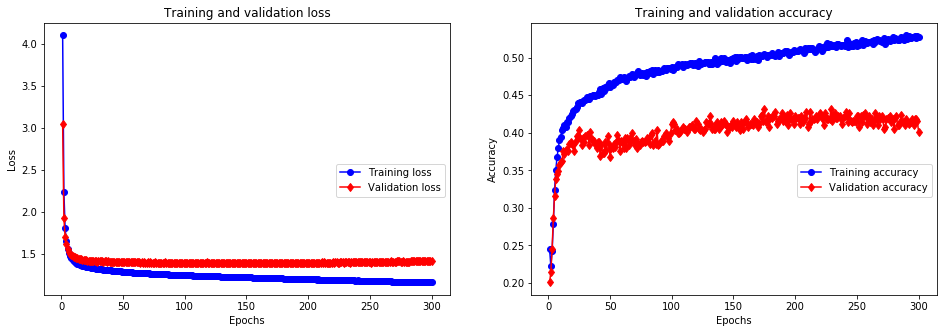

In [54]:
# check the progress with epochs
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']


epochs_tick = range(1,len(loss)+1)
plt.figure(figsize=(16,5))

# plot the learning curves for the loss function 
plt.subplot(1, 2, 1)
plt.plot(epochs_tick,loss,'bo-',label='Training loss')
plt.plot(epochs_tick,val_loss,'rd-',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1, 0.5))

# plot the learning curves for accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_tick,acc,'bo-',label='Training accuracy')
plt.plot(epochs_tick,val_acc,'rd-',label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()

In [56]:
test_ave, drop_idx_test = average(test_seq,initial_weight,embedding_dim)
print(testY.shape)
testY = np.delete(testY,drop_idx_test,axis=0)
print(test_ave.shape,testY.shape)

(1246, 5)
(1219, 25) (1219, 5)


In [60]:
clf_nn.evaluate(test_ave, testY, batch_size=128)

1219/1219 [==============================] - 0s 6us/step


[1.3226758950650448, 0.4257588195839898]

### 5.3 - LSTM

In [62]:
# delete empty sequences

train_seq_pad = np.delete(train_seq_pad,drop_idx,axis=0)
test_seq_pad = np.delete(test_seq_pad,drop_idx_test,axis=0)
print(train_seq_pad.shape,trainY.shape)

(4924, 10) (4924, 5)


In [81]:
clf_lstm = Sequential()
clf_lstm.add(Embedding(max_words+1,embedding_dim,weights=[initial_weight],trainable=False,input_length=max_len))
#clf_lstm.add(Dense(32,activation='relu',input_shape=(embedding_dim,)))
clf_lstm.add(Flatten())
clf_lstm.add(Dropout(0.2))
#clf_lstm.add(Dense(256,activation='relu'))
clf_lstm.add(Dense(32,activation='relu'))
clf_lstm.add(Dropout(0.2))
clf_lstm.add(Dense(5,activation='softmax'))

clf_lstm.summary()


opt = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
clf_lstm.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 10, 25)            125025    
_________________________________________________________________
flatten_7 (Flatten)          (None, 250)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                8032      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 165       
Total params: 133,222
Trainable params: 8,197
Non-trainable params: 125,025
_________________________________________________________________


In [82]:
history_lstm = clf_lstm.fit(train_seq_pad,trainY,epochs=50,batch_size=32,validation_split=0.1)

Train on 4431 samples, validate on 493 samples
Epoch 1/50
4431/4431 [==============================] - 0s 109us/step - loss: 1.6891 - acc: 0.2534 - val_loss: 1.5457 - val_acc: 0.2738
Epoch 2/50
4431/4431 [==============================] - 0s 46us/step - loss: 1.5049 - acc: 0.3286 - val_loss: 1.4963 - val_acc: 0.3469
Epoch 3/50
4431/4431 [==============================] - 0s 47us/step - loss: 1.4410 - acc: 0.3627 - val_loss: 1.4661 - val_acc: 0.3489
Epoch 4/50
4431/4431 [==============================] - 0s 46us/step - loss: 1.3875 - acc: 0.3929 - val_loss: 1.4536 - val_acc: 0.3529
Epoch 5/50
4431/4431 [==============================] - 0s 45us/step - loss: 1.3651 - acc: 0.4008 - val_loss: 1.4550 - val_acc: 0.3489
Epoch 6/50
4431/4431 [==============================] - 0s 47us/step - loss: 1.3574 - acc: 0.4195 - val_loss: 1.4413 - val_acc: 0.3550
Epoch 7/50
4431/4431 [==============================] - 0s 47us/step - loss: 1.3299 - acc: 0.4351 - val_loss: 1.4279 - val_acc: 0.3732
Epoch 8

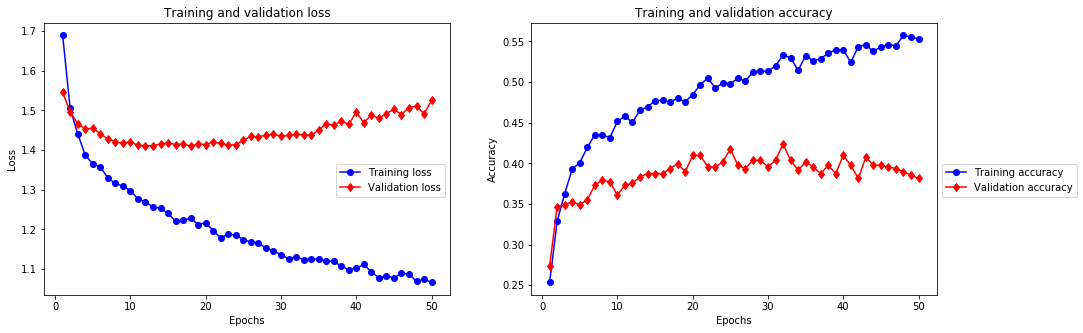

In [83]:
# check the progress with epochs
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']

acc = history_lstm.history['acc']
val_acc = history_lstm.history['val_acc']


epochs_tick = range(1,len(loss)+1)
plt.figure(figsize=(16,5))

# plot the learning curves for the loss function 
plt.subplot(1, 2, 1)
plt.plot(epochs_tick,loss,'bo-',label='Training loss')
plt.plot(epochs_tick,val_loss,'rd-',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1, 0.5))

# plot the learning curves for accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_tick,acc,'bo-',label='Training accuracy')
plt.plot(epochs_tick,val_acc,'rd-',label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()

In [84]:
clf_lstm.evaluate(test_seq_pad, testY)

1219/1219 [==============================] - 0s 20us/step


[1.3957427905855655, 0.3945857260049221]